## **Project Description**

**Description:** This notebook trains and tests a data set to recognize emotions from a dataset of faces. There are seven categories of facial expression (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

The data set that I am using is the FER-2013 dataset, which consists of 48x48 pixel grayscale images of faces.
The training set consists of 28,709 images, and the test set consists of 3,589 images.


##**Environment Setup**

my collab was being weird so i added this to fix it :)

In [ ]:
pip uninstall torch torchvision torchaudio -y

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121


In [ ]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.7 MB/s eta 0:00:00


In [ ]:
import torch

# Check PyTorch version
print("PyTorch Version:", torch.__version__)

# Check CUDA availability and version
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)

# Check GPU
if torch.cuda.is_available():
    print("GPU Device Name:", torch.cuda.get_device_name(0))

PyTorch Version: 2.5.1+cu121
CUDA Available: True
CUDA Version: 12.1
GPU Device Name: Tesla T4


## **Loading Data**


This section imports necessary modules and imports the FER-13 Dataset from Kaggle. It sets up the train and test datasets and converts all of the data to tensors.

In [1]:
# Importing necessary modules
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import cv2
import random
import torch
import torchvision
import torchvision.transforms as transforms
import kagglehub

In [2]:
# Importing kaggle path
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

100%|██████████| 60.3M/60.3M [00:00<00:00, 97.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [3]:
# Load FER-2013 dataset
train_dir = os.path.join(path, "train")
test_dir = os.path.join(path, "test")

In [4]:
# Defining transformations for grayscale images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure images are grayscale
    transforms.Resize((48, 48)),                 # Resize if needed
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
# Custom Dataset Class
class FER2013Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))  # Assuming subdirectories are class names

        # Load images and labels
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.data.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label

In [6]:
# Create datasets and dataloaders
batch_size = 64

trainset = FER2013Dataset(train_dir, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = FER2013Dataset(test_dir, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Define class names
classes = sorted(os.listdir(train_dir))

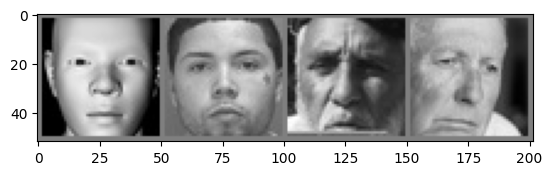

neutral neutral angry sad  


In [7]:
# Visualize some images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images[:4]

# Show images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## **Defining the CNN**

This code defines a CNN with four convolutional layers (each followed by batch normalization, ReLU activation, and max-pooling), a dropout layer to prevent overfitting, and three fully connected layers for classification. The network is uses cross-entropy loss for optimization and the Adam optimizer to train the model.

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, len(classes))

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [9]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

In [12]:
loss_list = []

## **Training the CNN**

In [13]:
# Training the CNN
num_epochs = 15
total_steps = len(trainloader)
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = loss_function(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            loss_list.append(running_loss / 10)
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 1.828
[1,    20] loss: 1.803
[1,    30] loss: 1.772
[1,    40] loss: 1.808
[1,    50] loss: 1.790
[1,    60] loss: 1.763
[1,    70] loss: 1.826
[1,    80] loss: 1.789
[1,    90] loss: 1.755
[1,   100] loss: 1.759
[1,   110] loss: 1.774
[1,   120] loss: 1.733
[1,   130] loss: 1.747
[1,   140] loss: 1.697
[1,   150] loss: 1.650
[1,   160] loss: 1.684
[1,   170] loss: 1.616
[1,   180] loss: 1.693
[1,   190] loss: 1.664
[1,   200] loss: 1.584
[1,   210] loss: 1.652
[1,   220] loss: 1.626
[1,   230] loss: 1.569
[1,   240] loss: 1.518
[1,   250] loss: 1.626
[1,   260] loss: 1.570
[1,   270] loss: 1.651
[1,   280] loss: 1.550
[1,   290] loss: 1.524
[1,   300] loss: 1.526
[1,   310] loss: 1.481
[1,   320] loss: 1.503
[1,   330] loss: 1.531
[1,   340] loss: 1.508
[1,   350] loss: 1.437
[1,   360] loss: 1.529
[1,   370] loss: 1.579
[1,   380] loss: 1.537
[1,   390] loss: 1.506
[1,   400] loss: 1.467
[1,   410] loss: 1.489
[1,   420] loss: 1.475
[1,   430] loss: 1.491
[1,   440] 

## **Loss Graph**

In [26]:
print(len(loss_list))

trimmed_loss_list = loss_list[0::11]
print(len(trimmed_loss_list))

660
60


In [23]:
epoch_list = []
for i in range(0,60):
  epoch_list.append((i/4)+1)

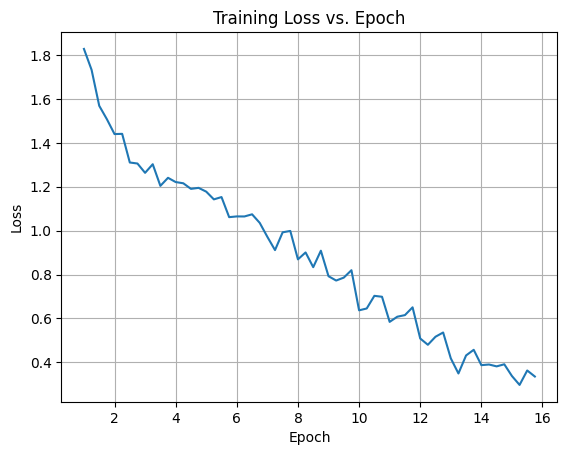

In [25]:
import matplotlib.pyplot as plt


plt.plot(epoch_list, trimmed_loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epoch")
plt.grid(True)
plt.show()

##**Evaluating the CNN**

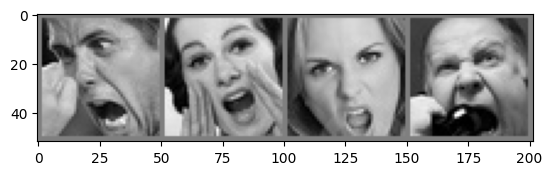

GroundTruth:  angry angry angry angry
Accuracy for class: angry is 46.3 %
Accuracy for class: disgust is 14.4 %
Accuracy for class: fear  is 34.5 %
Accuracy for class: happy is 70.9 %
Accuracy for class: neutral is 46.4 %
Accuracy for class: sad   is 47.0 %
Accuracy for class: surprise is 57.8 %


In [14]:
# Evaluating the CNN
dataiter = iter(testloader)
images, labels = next(dataiter)
images_display = images[:4]
imshow(torchvision.utils.make_grid(images_display))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Per-class accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [15]:
outputs = net(images)

In [16]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  fear  surprise surprise surprise


In [17]:
# Accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total:.2f} %')

Accuracy of the network on the test images: 51.80 %


In [18]:
# Per-class accuracy
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: angry is 46.7 %
Accuracy for class: disgust is 14.4 %
Accuracy for class: fear  is 34.8 %
Accuracy for class: happy is 71.0 %
Accuracy for class: neutral is 47.6 %
Accuracy for class: sad   is 47.7 %
Accuracy for class: surprise is 57.4 %
